### Manuk Melqonyan's model

# Wine Quality Prediction with  binary and 3-class classification<a id="0"></a> 

## Data Exploration and Processing<a id="0"></a> 

In [1]:
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

%matplotlib inline
np.random.seed(26)

In [2]:
wine = pd.read_csv('winequalityN.csv').rename(columns=lambda x: x.replace(" ","_"))

## Data exploration

In [3]:
wine.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
wine = wine.dropna(how = 'any')
wine.isnull().any()

type                    False
fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [5]:
# check data unbalance (The data has not a large unbalance with respect of the target value.)
# explore the target variable: quality
qualitydata = wine.quality.value_counts().sort_index()
qualitydata_df = pd.DataFrame({'Quality Level': qualitydata.index,'Frequency': qualitydata.values})
qualitydata_df

,Quality Level,Frequency
0,3,30
1,4,214
2,5,2128
3,6,2820
4,7,1074
5,8,192
6,9,5


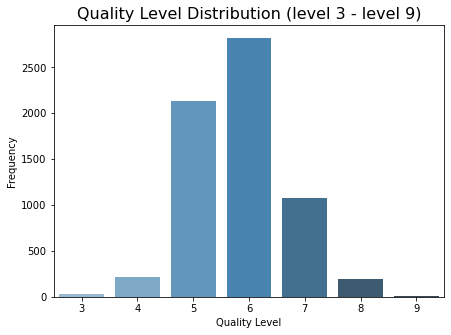

In [6]:
# visualize target variable
plt.figure(figsize=(7,5))
sns.barplot(x = 'Quality Level', y ="Frequency", data = qualitydata_df,palette="Blues_d")
plt.title('Quality Level Distribution (level 3 - level 9)',fontsize=16)
plt.show()

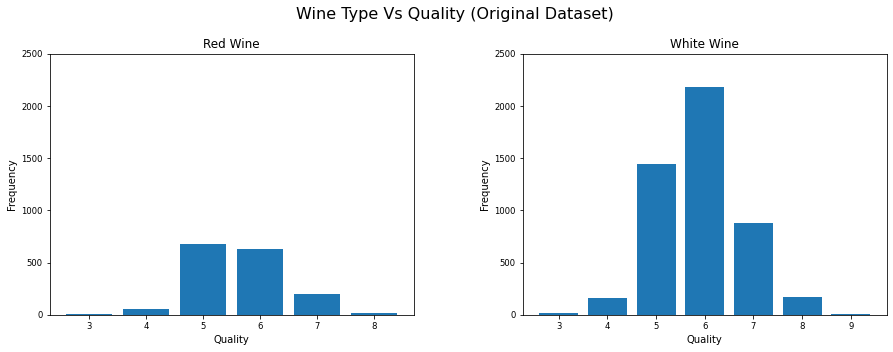

In [7]:
fig = plt.figure(figsize = (15, 5))
title = fig.suptitle("Wine Type Vs Quality (Original Dataset)", fontsize=16)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wine.quality[wine.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1])


ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wine.quality[wine.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1])

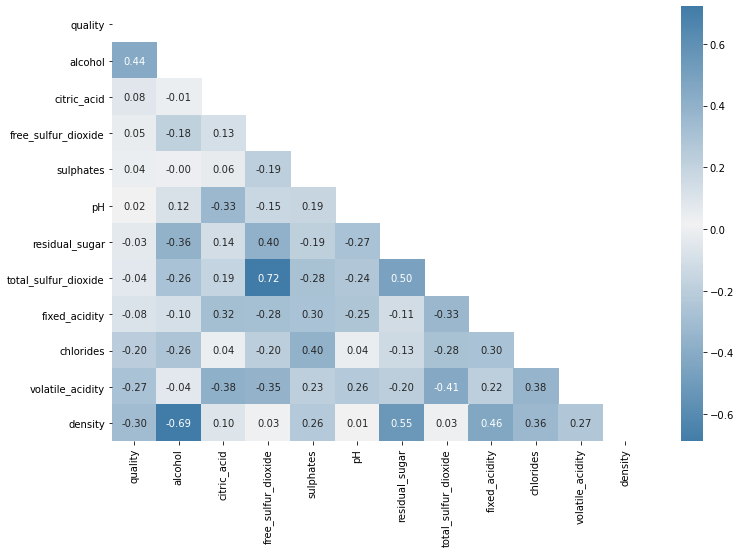

In [8]:
corr = wine.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr, cmap=sns.diverging_palette(600, 600, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
# sns.set(font_scale=1.0)
cols = wine.columns
cols = cols.drop('quality')

plt.show()

## Data exploration for binary classification

In [9]:
wine2 = wine
wine2['quality_label'] = (wine2['quality'] > 5.5)*1

wine2.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [10]:
wine.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [11]:
# explore the binary target variable: quality_label
qualitydata2 = wine2.quality_label.value_counts().sort_index()
qualitydata2_df = pd.DataFrame({'Quality Label': qualitydata2.index,'Frequency': qualitydata2.values})
qualitydata2_df

,Quality Label,Frequency
0,0,2372
1,1,4091


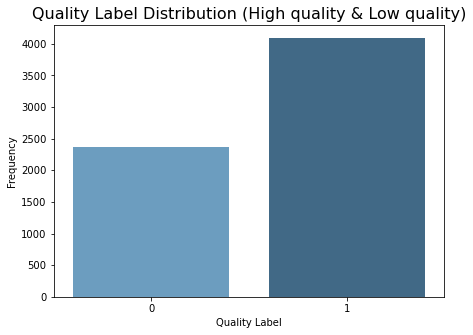

In [12]:
plt.figure(figsize=(7,5))
sns.barplot(x = 'Quality Label', y ="Frequency", data = qualitydata2_df,palette="Blues_d")
plt.title('Quality Label Distribution (High quality & Low quality)',fontsize=16)
plt.show()

## Data exploration for 3-class classification

In [13]:
wine3 = wine
wine3['quality_level'] = wine3.quality.apply(lambda q: 'Level C' if q <= 4 
                                             else 'Level B' if q <= 6 
                                             else 'Level A')
wine3.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_level
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1,Level B
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,Level B
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,Level B
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,Level B
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,Level B


In [14]:
qualitydata3 = wine3.quality_level.value_counts().sort_index()
qualitydata3_df = pd.DataFrame({'Quality Level': qualitydata3.index,'Frequency': qualitydata3.values})
qualitydata3_df

,Quality Level,Frequency
0,Level A,1271
1,Level B,4948
2,Level C,244


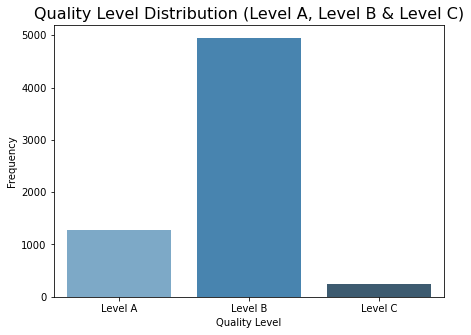

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(x = 'Quality Level', y ="Frequency", data = qualitydata3_df,palette="Blues_d")
plt.title('Quality Level Distribution (Level A, Level B & Level C)',fontsize=16)
plt.show()

## 1.2 Data Processing

In [16]:
wine.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_level
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1,Level B
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,Level B
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,Level B
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,Level B
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,Level B


In [17]:
# get dummies for variable type

wine['type'].replace(to_replace={'white':1,'red':0}, inplace=True)
wine

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_level
0,1,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1,Level B
1,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1,Level B
2,1,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1,Level B
3,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,Level B
4,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,Level B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,0,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1,Level B
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0,Level B
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,Level B
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0,Level B


In [18]:
# Selecting the input and output features for multi-classification tasks

features = ['type',
            'fixed_acidity',
            'volatile_acidity',
            'citric_acid',
            'residual_sugar',
            'chlorides',
            'free_sulfur_dioxide',
            'total_sulfur_dioxide',
            'density',
            'pH',
            'sulphates',
            'alcohol']

target = ['quality_level']

In [19]:
# Split dataset into training and test datasets
x = wine[features]
y = wine[target].values.ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=200)

In [20]:
wine2

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_level
0,1,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1,Level B
1,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1,Level B
2,1,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1,Level B
3,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,Level B
4,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,Level B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,0,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1,Level B
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0,Level B
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,Level B
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0,Level B


In [21]:
# Selecting the input and output features for binary classification tasks
features2 = ['type',
             'fixed_acidity',
             'volatile_acidity',
             'citric_acid',
             'residual_sugar',
             'chlorides',
             'free_sulfur_dioxide',
             'total_sulfur_dioxide',
             'density',
             'pH',
             'sulphates',
             'alcohol']

target2 = ['quality_label']

x2 = wine2[features2]
y2 = wine2[target2].values.ravel()

In [22]:
# Split dataset into train ant test datasets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=200)

# Modeling<a id="1"></a> 

In [23]:
def get_results_multi(clf,clf_name,x_train,y_train,x_test,y_test):
    y_pred = clf.predict(x_test)
    print('Training Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_train, clf.predict(x_train))))    
    print('Test Accuracy('+clf_name+'): {:2.2%}\n'.format(accuracy_score(y_test, clf.predict(x_test))))
    print('Classification Report('+clf_name+'): \n' + classification_report(y_test, y_pred))
    
    probs = clf.predict_proba(x_test) # Predict class probabilities of the input samples 
    preds = probs[:,1]
    
    
    print('5 fold Cross Validation('+clf_name+'):')
    cv_accuracy = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix ('+clf_name+')',fontsize=16)
    
    tmp = pd.DataFrame({'Feature': features, 'Feature Importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature Importance',ascending=False)
    plt.figure(figsize = (10,6))
    plt.title('Features Importance',fontsize=16)
    s = sns.barplot(x='Feature',y='Feature Importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show() 

In [24]:
def get_results_binary(clf,clf_name,x_train,y_train,x_test,y_test):
    y_pred = clf.predict(x_test)
    print('Training Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_train, clf.predict(x_train))))    
    print('Test Accuracy('+clf_name+'): {:2.2%}\n'.format(accuracy_score(y_test, clf.predict(x_test))))
    print('Classification Report('+clf_name+'): \n' + classification_report(y_test, y_pred))
    
    probs = clf.predict_proba(x_test) # Predict class probabilities of the input samples 
    preds = probs[:,1]
    fpr,tpr,threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr,tpr)
    print('ROC AUC Score('+clf_name+'): {:2.2%}\n'.format(roc_auc))
    
    
    print('5 fold Cross Validation('+clf_name+'):')
    cv_accuracy = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))
    cv_recall = cross_val_score(clf, x_train, y_train, cv=5, scoring='recall')
    print('Recall: {:2.2%}'.format(np.mean(cv_recall)))
    cv_precision = cross_val_score(clf, x_train, y_train, cv=5, scoring='precision')
    print('Precision: {:2.2%}'.format(np.mean(cv_precision)))
    cv_f1 = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1')
    print('F1-score: {:2.2%}'.format(np.mean(cv_f1)))
    cv_roc_auc = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
    print('ROC AUC Score: {:2.2%}'.format(np.mean(cv_roc_auc)))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix ('+clf_name+')',fontsize=16)
    
    
    # calculate the Optimum Threshold
    for i in range(len(fpr)):
        if fpr[i] + tpr[i] >= 1:
            i = i -1
            break

    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, lw=1,label='ROC Curve(area = %0.2f)    Optimum Threshold = %0.2f' % (roc_auc, threshold[i]))
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ('+clf_name+')',fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
    
    tmp = pd.DataFrame({'Feature': features, 'Feature Importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature Importance',ascending=False)
    plt.figure(figsize = (10,6))
    plt.title('Features Importance',fontsize=16)
    s = sns.barplot(x='Feature',y='Feature Importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show() 

In [25]:
def get_results_multi_withoutFeatureImportance(clf,clf_name,x_train,y_train,x_test,y_test):
    y_pred = clf.predict(x_test)
    print('Training Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_train, clf.predict(x_train))))    
    print('Test Accuracy('+clf_name+'): {:2.2%}\n'.format(accuracy_score(y_test, clf.predict(x_test))))
    print('Classification Report('+clf_name+'): \n' + classification_report(y_test, y_pred))
    
    probs = clf.predict_proba(x_test) # Predict class probabilities of the input samples 
    preds = probs[:,1]
    
    
    print('5 fold Cross Validation('+clf_name+'):')
    cv_accuracy = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix ('+clf_name+')',fontsize=16)

In [26]:
def get_results_binary_withoutFeatureImportance(clf,clf_name,x_train,y_train,x_test,y_test):
    y_pred = clf.predict(x_test)
    print('Training Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_train, clf.predict(x_train))))    
    print('Test Accuracy('+clf_name+'): {:2.2%}\n'.format(accuracy_score(y_test, clf.predict(x_test))))
    print('Classification Report('+clf_name+'): \n' + classification_report(y_test, y_pred))
    
    probs = clf.predict_proba(x_test) # Predict class probabilities of the input samples 
    preds = probs[:,1]
    fpr,tpr,threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr,tpr)
    print('ROC AUC Score('+clf_name+'): {:2.2%}\n'.format(roc_auc))
    
    
    print('5 fold Cross Validation('+clf_name+'):')
    cv_accuracy = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))
    cv_recall = cross_val_score(clf, x_train, y_train, cv=5, scoring='recall')
    print('Recall: {:2.2%}'.format(np.mean(cv_recall)))
    cv_precision = cross_val_score(clf, x_train, y_train, cv=5, scoring='precision')
    print('Precision: {:2.2%}'.format(np.mean(cv_precision)))
    cv_f1 = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1')
    print('F1-score: {:2.2%}'.format(np.mean(cv_f1)))
    cv_roc_auc = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
    print('ROC AUC Score: {:2.2%}'.format(np.mean(cv_roc_auc)))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix ('+clf_name+')',fontsize=16)
    
    
    # calculate the Optimum Threshold
    for i in range(len(fpr)):
        if fpr[i] + tpr[i] >= 1:
            i = i -1
            break

    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, lw=1,label='ROC Curve(area = %0.2f)    Optimum Threshold = %0.2f' % (roc_auc, threshold[i]))
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ('+clf_name+')',fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [27]:
def compare_accuracy(clf,clf_name):
    print('5 fold Cross Validation('+clf_name+'):')
    cv_accuracy = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))

# Decision Tree Modeling<a id="1"></a> 

## Multi-class Classification

In [28]:
# Fit on train set
dt_clf = DecisionTreeClassifier(random_state = 42, 
                             criterion = 'entropy',
                             max_depth = 5,
                             min_samples_leaf = 2,                                                   
                            )
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       random_state=42)

Training Accuracy(Decision Tree - Multiclass Classification): 80.08%
Test Accuracy(Decision Tree - Multiclass Classification): 79.04%

Classification Report(Decision Tree - Multiclass Classification): 
              precision    recall  f1-score   support

     Level A       0.58      0.36      0.44       256
     Level B       0.82      0.93      0.87       997
     Level C       0.40      0.05      0.09        40

    accuracy                           0.79      1293
   macro avg       0.60      0.45      0.47      1293
weighted avg       0.76      0.79      0.76      1293

5 fold Cross Validation(Decision Tree - Multiclass Classification):
Accuracy: 79.03%


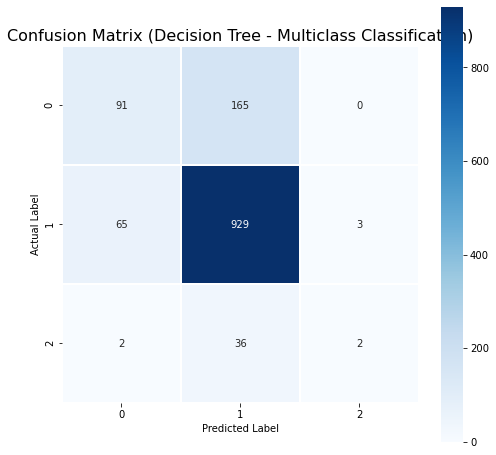

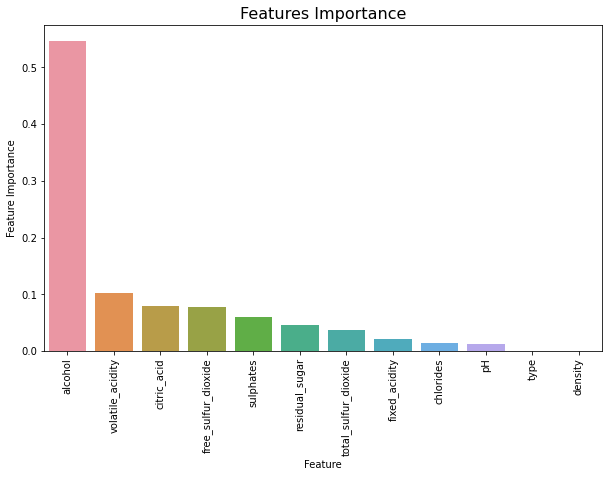

In [29]:
get_results_multi(dt_clf,'Decision Tree - Multiclass Classification',x_train,y_train,x_test,y_test)

## Binary Classification

In [30]:
# Fit on train set
# wine_clf = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=200)
dt_clf2 = DecisionTreeClassifier(
                              max_depth = 5,
                              random_state = 42,
                              criterion = 'entropy',                             
                              min_samples_leaf = 2
                             )
dt_clf2.fit(x2_train, y2_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       random_state=42)

Training Accuracy(Decision Tree - Binary Classification): 76.27%
Test Accuracy(Decision Tree - Binary Classification): 74.86%

Classification Report(Decision Tree - Binary Classification): 
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       459
           1       0.82      0.78      0.80       834

    accuracy                           0.75      1293
   macro avg       0.73      0.74      0.73      1293
weighted avg       0.75      0.75      0.75      1293

ROC AUC Score(Decision Tree - Binary Classification): 79.67%

5 fold Cross Validation(Decision Tree - Binary Classification):
Accuracy: 73.48%
Recall: 77.56%
Precision: 79.83%
F1-score: 78.65%
ROC AUC Score: 78.89%


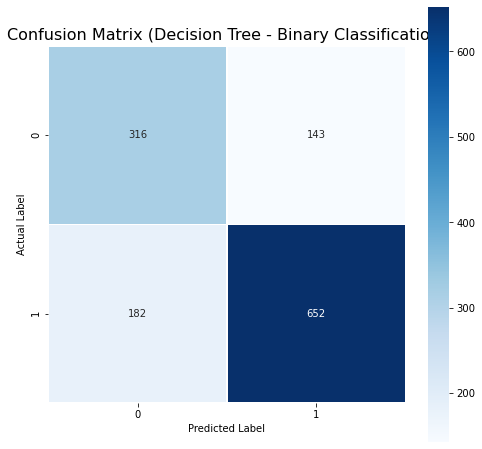

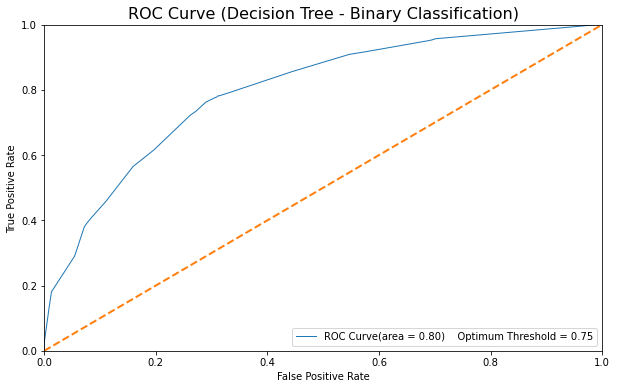

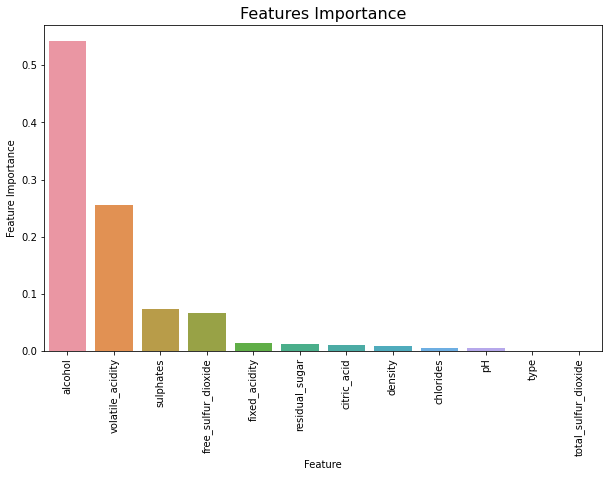

In [31]:
get_results_binary(dt_clf2,'Decision Tree - Binary Classification',x2_train,y2_train,x2_test,y2_test)

# Random Forest Modeling<a id="2"></a> 

## Multi-class Classification

In [32]:
rf_clf = RandomForestClassifier(random_state = 42,
                                criterion = 'entropy', 
                                max_depth=6,
                                min_samples_leaf = 2,
                                n_estimators = 150)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       n_estimators=150, random_state=42)

Training Accuracy(Random Forest - Multiclass Classification): 81.08%
Test Accuracy(Random Forest - Multiclass Classification): 79.89%

Classification Report(Random Forest - Multiclass Classification): 
              precision    recall  f1-score   support

     Level A       0.72      0.23      0.35       256
     Level B       0.80      0.98      0.88       997
     Level C       0.00      0.00      0.00        40

    accuracy                           0.80      1293
   macro avg       0.51      0.40      0.41      1293
weighted avg       0.76      0.80      0.75      1293

5 fold Cross Validation(Random Forest - Multiclass Classification):
Accuracy: 78.92%


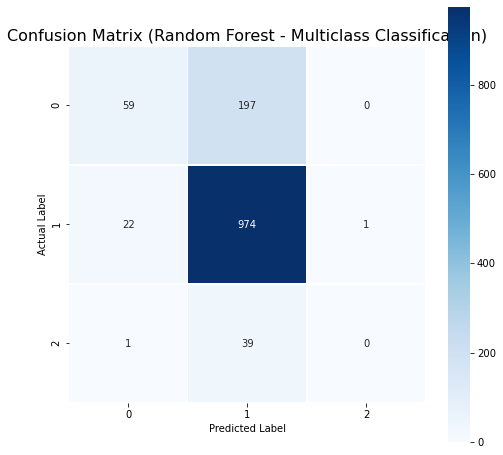

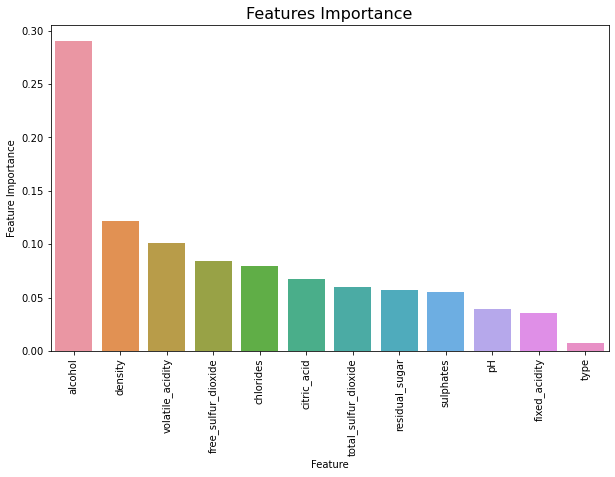

In [33]:
get_results_multi(rf_clf,'Random Forest - Multiclass Classification',x_train,y_train,x_test,y_test)

## Binary Classification

In [34]:
rf_clf2 = RandomForestClassifier(random_state = 42,
                                 criterion = 'entropy',                             
                                 min_samples_leaf = 2,
                                 max_depth=7,
                                 n_estimators = 175)
rf_clf2.fit(x2_train, y2_train)

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       n_estimators=175, random_state=42)

Training Accuracy(Random Forest - Binary Classification): 81.62%
Test Accuracy(Random Forest - Binary Classification): 76.57%

Classification Report(Random Forest - Binary Classification): 
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       459
           1       0.79      0.86      0.83       834

    accuracy                           0.77      1293
   macro avg       0.75      0.73      0.73      1293
weighted avg       0.76      0.77      0.76      1293

ROC AUC Score(Random Forest - Binary Classification): 83.16%

5 fold Cross Validation(Random Forest - Binary Classification):
Accuracy: 77.68%
Recall: 85.72%
Precision: 80.24%
F1-score: 82.88%
ROC AUC Score: 84.65%


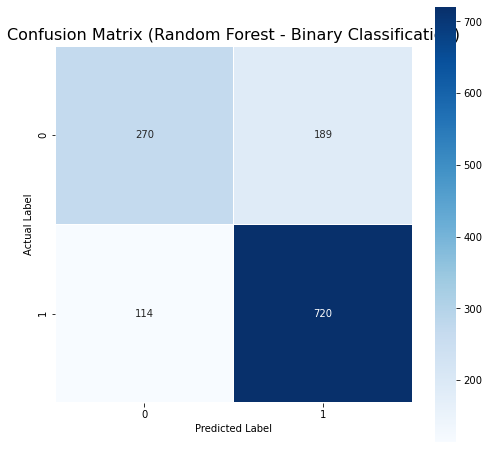

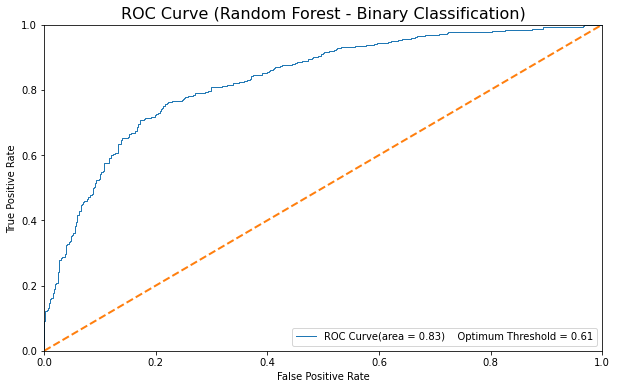

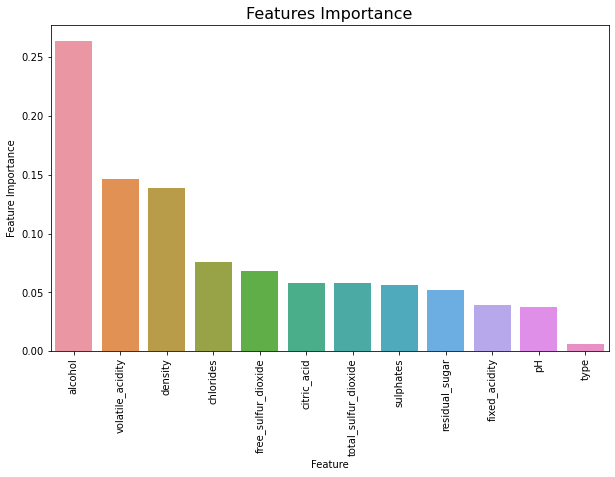

In [35]:
get_results_binary(rf_clf2,'Random Forest - Binary Classification',x2_train,y2_train,x2_test,y2_test)

# Final Results<a id="5"></a> 

In [36]:
# Random Forest is works better than Decision Tree

compare_accuracy(dt_clf,'Decision Tree - Multiclass')
compare_accuracy(dt_clf2,'Decision Tree - Binary')
compare_accuracy(rf_clf,'Random Forest - Multiclass')
compare_accuracy(rf_clf2,'Random Forest - Binary')

5 fold Cross Validation(Decision Tree - Multiclass):
Accuracy: 79.03%
5 fold Cross Validation(Decision Tree - Binary):
Accuracy: 79.03%
5 fold Cross Validation(Random Forest - Multiclass):
Accuracy: 78.92%
5 fold Cross Validation(Random Forest - Binary):
Accuracy: 79.79%
